<a href="https://colab.research.google.com/github/alanbseo/FlickrWorkshopUFZ/blob/master/UFZ_2_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this session, we are going to do image annotation with the bounding box using Mask Region Convolutional Neural Networks (M_RCNN;  https://github.com/matterport/Mask_RCNN). M_RCNN is one of the recent object detection algorithms such as Faster RCNN, YOLO, SSD etc. Those have pros and cons and we need to find a right framework for having reasonably accurate annotation in relatively short time. Here gives an example using the pre-trained model to detect and segment objects from Flickr photos. The demo is primarily based on the original demo of the developer ()https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb), but for convience we have prepared the dataset and the Google CoLab enviornment. Therefore, for license issues, the repository will be closed after the workshop; please contact us if you need help or advice on using the model. 

When you are done with the exercise, we recommend continue doing the exercise using the resources on the original repository. First thing you want to do would be training the engine by your own data (https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb) and test that with new images.


References:

Speed/accuracy trade-offs for modern convolutional object detectors

https://arxiv.org/abs/1611.10012

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt



print(os.path.abspath("."))
print(os.getcwd())
print(os.listdir())
 

/content
/content
['.config', 'sample_data']


In [0]:
 
import ssl

### Avoid certificat error (source: https://stackoverflow.com/questions/27835619/urllib-and-ssl-certificate-verify-failed-error)
import requests
requests.packages.urllib3.disable_warnings()

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context



In [0]:
# we removed the use of gdrive. Later if you want you can do like such.. 

# from google.colab import drive
# drive.mount('/content/googledrive')

# print(os.path.abspath("googledrive"))

# print(os.path.abspath("."))
# print(os.getcwd())
# print(os.listdir())
# os.chdir("/content/googledrive/My Drive/Colab Notebooks")


In [3]:
print(os.listdir("."))

 



['.config', 'sample_data']


If something suspicious and if the result of the above cell is just
sample_data/
then please run the script below again.

In [4]:
!git clone https://github.com/matterport/Mask_RCNN.git /content/Mask_RCNN


Cloning into '/content/Mask_RCNN'...
remote: Enumerating objects: 952, done.
remote: Total 952 (delta 0), reused 0 (delta 0), pack-reused 952
Receiving objects: 100% (952/952), 127.12 MiB | 19.26 MiB/s, done.
Resolving deltas: 100% (545/545), done.


In [5]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")
print(os.listdir(ROOT_DIR))



['requirements.txt', 'MANIFEST.in', 'images', 'README.md', '.gitignore', 'samples', 'mrcnn', 'setup.py', 'LICENSE', '.git', 'assets', 'setup.cfg']


The heading "!" tells the notebook to run system commands. You can use pip (or apt) to install packages.

For installing system packages, 

```
!apt update && apt install -y PACKAGENAME
```
 

In [6]:
!pip3 install mrcnn # M_RCNN package


    100% |████████████████████████████████| 61kB 5.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn



The demo is using a model trained on the MS-COCO dataset . The configurations of this model are in the CocoConfig class in coco.py. For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the CocoConfig class and override the attributes you need to change.


In [7]:

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco
#from pycocotools.coco import COCO as coco
#from pycocotools.cocoeval import COCOeval
#from pycocotools import mask as maskUtils

# the above part is often troublesome if you do it locally. The installation of pycocotools requires you to install Cython and some other crucial packages. 


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


In [8]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

# Create Model and Load Trained Weights

It 

In [9]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
# They are only 81 but further has an hierarchical structure. 
# @todo detail this part 
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

len(class_names)

81

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


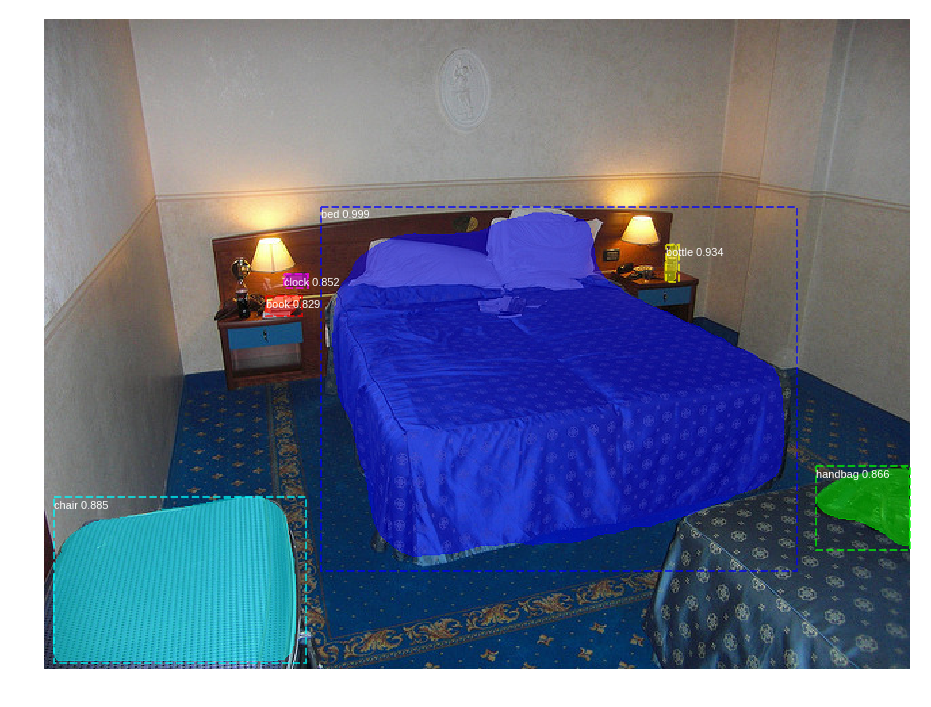

In [11]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
# As we randomly sample, the target image changes every time you run the cell.
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


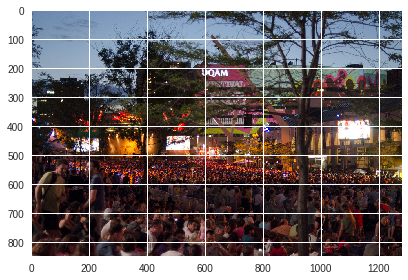

In [20]:
# Load a image from Internet
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Festival_international_de_jazz_de_Montr%C3%A9al_%287663675578%29.jpg/1280px-Festival_international_de_jazz_de_Montr%C3%A9al_%287663675578%29.jpg"
 
image = skimage.io.imread(image_url)
skimage.io.imshow(image)



Processing 1 images
image                    shape: (848, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


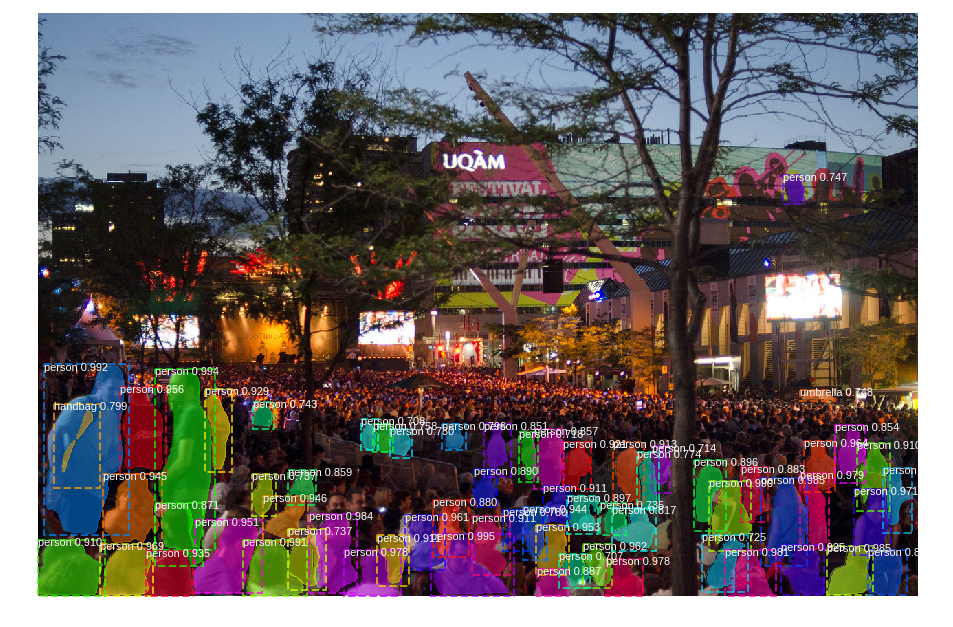

In [21]:
#
# Run detection
results = model.detect([image], verbose=1)

# print(results)


# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Some images are well recognised, some other not, and occasionally it says there is nothing to tell! Thnik about the reason why it sometimes work but not always. What can we do to improve its capability? 